# $\fbox{3-3}$ 健診結果別入院・外来レコードの擬似生成

## データの読み込みと加工

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc
import math
import pickle

# 本書 1-3 章の関数群を含む自作ライブラリ
import mylibs.mylib1 as mylib1
import mylibs.mylib2 as mylib2
import mylibs.mylib3 as mylib3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 8
pd.options.display.max_columns = 12

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# pd.DataFrame の表示行数・列数を指定
pd.options.display.max_rows = 8
pd.options.display.max_columns = 12

### 血圧分類属性付き加入者情報データ

In [2]:
df_info = pd.read_csv('./pseudo_medical/records/incl_bp/info.csv')

print(df_info.shape)
df_info.head()

(4815, 8)


,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death,bp_class
0,i000000,M,1,1952/06,2010/01,2013/09,0,1
1,i000001,F,2,1972/11,2010/01,2019/12,0,0
2,i000002,M,1,1978/03,2010/01,2016/09,0,0
3,i000003,M,2,1989/03,2010/01,2013/12,0,0
4,i000006,M,1,1973/11,2010/04,2013/09,0,0


### 月次入院発生率

In [3]:
df_admission = pd.read_csv('./public_stats/processed/ps_admission.csv')
df_admission_cumrate = mylib2.make_admission_cumrate(df_admission)

print(df_admission_cumrate.shape)
df_admission_cumrate.head()

(32, 22)


,sex,alb_min,alb_max,A00,C00,D50,...,N00,O00,P00,Q00,R00,S00
0,M,0.0,0.0,0.0,0.0,0.0,...,0.005288,0.005288,0.021153,0.021153,0.021153,0.021153
1,M,1.0,4.0,0.0,0.0,0.0,...,0.002581,0.002581,0.002581,0.003872,0.003872,0.005163
2,M,5.0,9.0,0.0,0.0,0.0,...,0.000969,0.000969,0.000969,0.000969,0.000969,0.001938
3,M,10.0,14.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000937
4,M,15.0,19.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000847


### 月次外来発生率

In [4]:
df_outpatient = pd.read_csv('./public_stats/processed/ps_outpatient.csv')

print(df_outpatient.shape)
df_outpatient.head()

(38, 22)


,sex,alb_min,alb_max,A00,C00,D50,...,N00,O00,P00,Q00,R00,S00
0,M,0.0,0.0,0.068748,0.010577,0.005288,...,0.010577,0.0,0.052883,0.063460,0.042307,0.037018
1,M,1.0,4.0,0.101963,0.002581,0.003872,...,0.010325,0.0,0.006453,0.019360,0.019360,0.064533
2,M,5.0,9.0,0.092074,0.004846,0.001938,...,0.007754,0.0,0.000969,0.006784,0.014538,0.066875
3,M,10.0,14.0,0.051562,0.003750,0.001875,...,0.002812,0.0,0.000000,0.005625,0.011250,0.105936
4,M,15.0,19.0,0.019475,0.003387,0.001693,...,0.003387,0.0,0.000000,0.002540,0.005927,0.070280


### 平均在院日数

In [5]:
df_days = pd.read_csv('./public_stats/processed/ps_days.csv')
less_age_75 = (df_days.alb_max < 75)
df_days = df_days.loc[less_age_75]

print(df_days.shape)
df_days.head()

(32, 22)


,sex,alb_min,alb_max,A00,C00,D50,...,N00,O00,P00,Q00,R00,S00
0,M,0.0,0.0,4.5,9.3,9.1,...,6.7,0.0,11.3,16.1,4.0,2.6
1,M,1.0,4.0,3.8,12.1,8.4,...,8.8,0.0,38.7,7.5,3.1,1.7
2,M,5.0,9.0,7.7,16.0,11.0,...,9.6,0.0,8.2,7.6,2.9,4.1
3,M,10.0,14.0,3.9,19.2,9.0,...,7.4,0.0,5.2,16.7,4.8,7.8
4,M,15.0,19.0,5.3,15.2,16.3,...,7.6,0.0,0.0,22.4,3.2,8.2


<IPython.core.display.Javascript object>


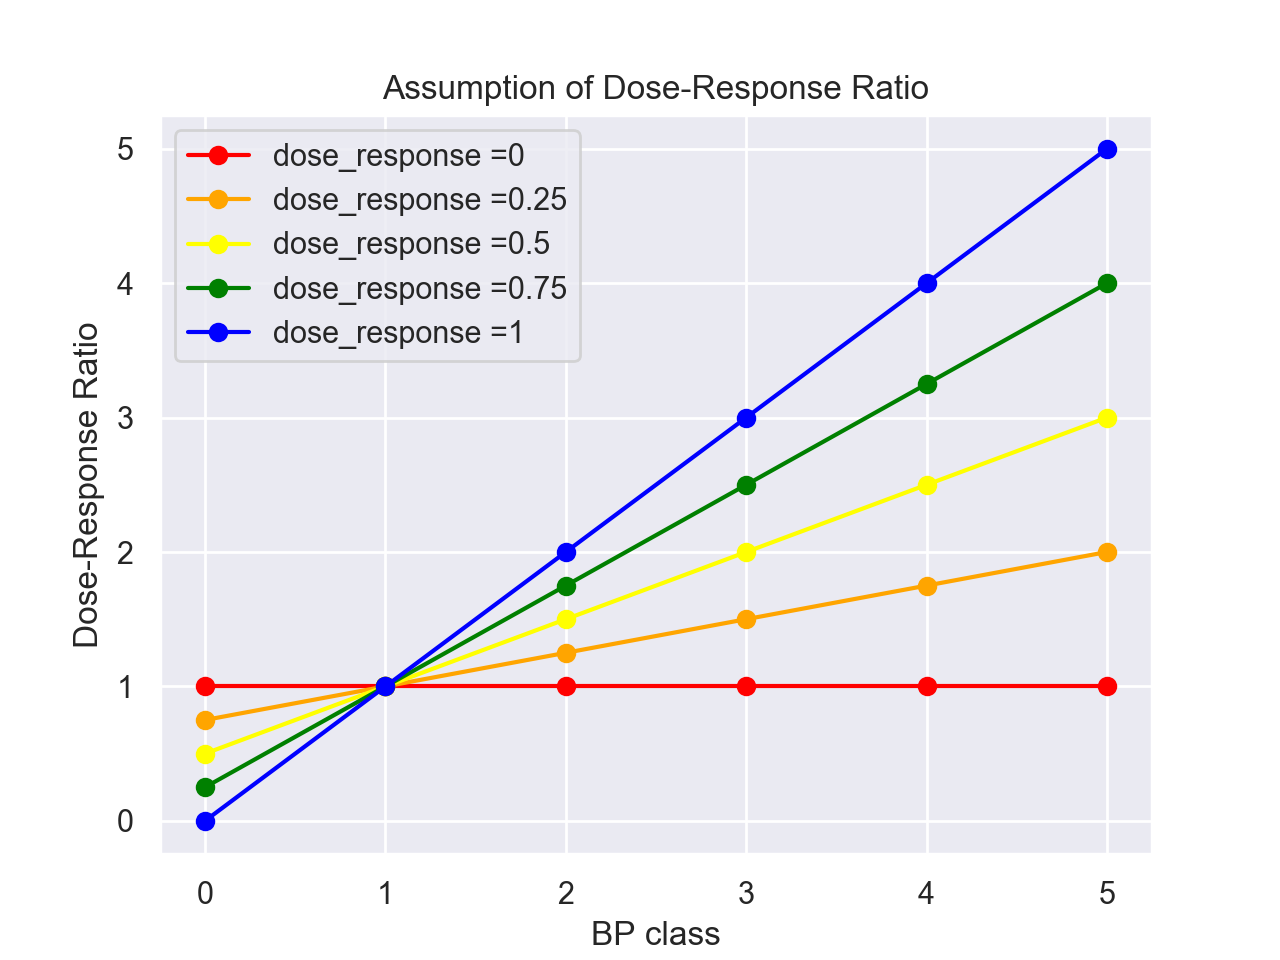

Text(0.5, 1.0, 'Assumption of Dose-Response Ratio')

In [6]:
import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)

bp_class = np.arange(6)
grads = [0, 0.25, 0.5, 0.75, 1]
colors = ['red', 'orange', 'yellow', 'green', 'blue']
for (dose_response, c) in zip(grads, colors):
    dose_response_ratio = (bp_class - 1) * dose_response + 1
    ax.plot(bp_class, dose_response_ratio, c=c, marker='o',
            label='dose_response ='+str(dose_response))

ax.legend(loc='best')
ax.set_xlabel('BP class')
ax.set_ylabel('Dose-Response Ratio')
ax.set_title('Assumption of Dose-Response Ratio')

## 関数の定義

In [7]:
def get_info_for_i(df_info, i):
    cols = ['iid', 'sex', 'birth_ym', 'start_obs_ym', 'end_obs_ym', 'bp_class']
    (iid, sex, birth_ym, start_obs_ym,
     end_obs_ym, bp_class) = df_info.iloc[i][cols]
    birth_t = mylib1.ym_to_t(birth_ym)
    start_obs_t = mylib1.ym_to_t(start_obs_ym)
    end_obs_t = mylib1.ym_to_t(end_obs_ym)
    return (iid, sex, birth_t, start_obs_t, end_obs_t, bp_class)


i = 0
(iid, sex, birth_t, start_obs_t, end_obs_t, bp_class) = get_info_for_i(df_info, i)

### 関数を組み合わせてコードを組む

In [8]:
import csv


dict_csv_paths = {'common': './pseudo_medical/records/incl_bp/commons.csv',
                  'disease': './pseudo_medical/records/incl_bp/diseases.csv',
                  'treatment': './pseudo_medical/records/incl_bp/treatments.csv'}

commons_csv = open(dict_csv_paths['common'], 'w')
open_common_object = csv.writer(commons_csv)
cols = ['iid', 'rid', 'ym', 'receipt_type', 'admission_ym', 'days']
open_common_object.writerow(cols)

diseases_csv = open(dict_csv_paths['disease'], 'w')
open_disease_object = csv.writer(diseases_csv)
cols = ['iid', 'rid', 'first_ym', 'icd10_code']
open_disease_object.writerow(cols)

treatments_csv = open(dict_csv_paths['treatment'], 'w')
open_treatment_object = csv.writer(treatments_csv)
cols = ['iid', 'rid', 'treatment_code']
open_treatment_object.writerow(cols)

dose_response = 0.5  # <-- 追加
rid = 'r00000000'
rs = 0


for i in np.arange(len(df_info)):  # df_info を上から順に参照
    gc.collect()
    # df_info の i 番目の (iid, sex, birth_t, start_obs_t, end_obs_t) を取得
    (iid, sex, birth_t, start_obs_t, end_obs_t, bp_class) = get_info_for_i(df_info, i)
    t = start_obs_t
    while start_obs_t <= t <= end_obs_t:
        alb = int(t - birth_t)
        # 入院累積発生率の pd.Series を取得
        ss_adm_cumrate = mylib2.get_ss_admission_cumrate(
            df_admission_cumrate, sex, alb)
        # 入院用に一様乱数 u(rs) (0 <= r <= 1)を生成 & ランダムシード更新
        (u, rs) = mylib2.get_random_num_for_adm(rs)
        # (入院発生？, 入院原因傷病 dis) = 入院乱数シミュレーション(u)
        dose_response_ratio = (bp_class - 1) * dose_response + 1  # <-- 追加
        (does_adm_occur, dis) = mylib2.get_admission_disease(
                                ss_adm_cumrate, u / dose_response_ratio)
        #                                         ---------------------
        #                                                  変更
        if does_adm_occur:
            mu = mylib2.get_avg_hospdays(df_days, sex, alb, dis)
            # 在院日数 days を指数分布(mu) で決定
            (days, rs) = mylib2.get_random_days(mu, rs)
            # 入院発生年月、入院は全て月央に発生すると仮定
            admission_ym = mylib1.t_to_ym(t)
            # 月をまたぐ継続入院でなくても次のコードブロックを実行
            does_hosp_continue = True
            m = 0  # 初月入院を 0、次月から月をまたぐごとに +1
            while does_hosp_continue:
                ym = mylib1.t_to_ym(t)
                rid = mylib2.make_new_rid(rid)
                # 共通レコード(入院)の発行
                # 共通レコード(入院)の作成
                df_common = mylib2.create_df_common_inpatient_after_m_months(
                            iid, rid, ym, admission_ym, days, m)
                mylib2.add_df_xxx_on_csv(open_common_object, df_common)
                # 傷病レコードの発行
                df_disease = mylib2.create_df_disease(iid, rid, admission_ym, dis)
                mylib2.add_df_xxx_on_csv(open_disease_object, df_disease)
                # 診療行為レコード(入院)の発行
                df_treatment = mylib2.create_df_treatment(iid, rid, 'A100')
                mylib2.add_df_xxx_on_csv(open_treatment_object, df_treatment)
                # 診療行為レコード(手術)を入院の 10% に発行
                (u, rs) = mylib2.get_random_num_for_adm(rs)
                if u <= 0.1:
                    df_treatment = mylib2.create_df_treatment(iid, rid, 'K000')
                    mylib2.add_df_xxx_on_csv(open_treatment_object, df_treatment)

                t = t + 1 / 12  # t を１ヶ月ずらす
                does_hosp_continue = (days - 15 - 30 * m > 0)
                m = m + 1

        else:  # 入院発生なし
            # 外来発生率 out(sex, alb) を取得
            ss_out_rate = mylib2.get_outpatient_rate(df_outpatient, sex, alb)
            # 外来用に一様乱数 u(rs) (0 <= r <= 1)を生成 & ランダムシード更新
            (us, rs) = mylib2.get_random_num_for_out(rs)
            us = us / dose_response_ratio  # <-- 追加
            # (外来発生？, 複数外来原因傷病 diss) = 外来乱数シミュレーション(u)
            (does_occur_outpatient, diss) \
                = mylib2.get_outpatient_diseases(ss_out_rate, us)
            if does_occur_outpatient:
                # 外来発生年月、外来は全て月央に発生すると仮定
                ym = mylib1.t_to_ym(t)
                for dis in diss:
                    rid = mylib2.make_new_rid(rid)
                    # 共通レコード(外来)の発行
                    # 共通レコード(外来) df_common(iid, rid, ym) の作成
                    df_common = mylib2.create_df_common(iid, rid, ym,
                                                      'outpatient', '-', 1)
                    mylib2.add_df_xxx_on_csv(open_common_object, df_common)
                    # 傷病レコードの発行
                    df_disease = mylib2.create_df_disease(iid, rid, ym, dis)
                    mylib2.add_df_xxx_on_csv(open_disease_object, df_disease)
                    # 診療行為レコード(外来)の発行
                    df_treatment = mylib2.create_df_treatment(iid, rid, 'A000')
                    mylib2.add_df_xxx_on_csv(open_treatment_object, df_treatment)
                    df_treatment = mylib2.create_df_treatment(iid, rid, 'F000')
                    mylib2.add_df_xxx_on_csv(open_treatment_object, df_treatment)
                    # 診療行為レコード(手術)を外来の 1% に発行
                    (u, rs) = mylib2.get_random_num_for_adm(rs)
                    if u <= 0.01:
                        df_treatment = mylib2.create_df_treatment(iid, rid, 'K000')
                        mylib2.add_df_xxx_on_csv(open_treatment_object, df_treatment)

            t = t + 1 / 12  # t を１ヶ月ずらす

commons_csv.close()
diseases_csv.close()
treatments_csv.close()

In [9]:
df_common = pd.read_csv('./pseudo_medical/records/incl_bp/commons.csv')

print(df_common.shape)
df_common.head()

(267415, 6)


,iid,rid,ym,receipt_type,admission_ym,days
0,i000000,r00000001,2010/01,outpatient,-,1
1,i000000,r00000002,2010/02,outpatient,-,1
2,i000000,r00000003,2010/02,outpatient,-,1
3,i000000,r00000004,2010/03,outpatient,-,1
4,i000000,r00000005,2010/04,outpatient,-,1


In [10]:
df_diseases = pd.read_csv('./pseudo_medical/records/incl_bp/diseases.csv')

print(df_diseases.shape)
df_diseases.head()

(267415, 4)


,iid,rid,first_ym,icd10_code
0,i000000,r00000001,2010/01,D50
1,i000000,r00000002,2010/02,H60
2,i000000,r00000003,2010/02,S00
3,i000000,r00000004,2010/03,G00
4,i000000,r00000005,2010/04,C00


In [11]:
df_treatments = pd.read_csv('./pseudo_medical/records/incl_bp/treatments.csv')

print(df_treatments.shape)
df_treatments.head()

(535269, 3)


,iid,rid,treatment_code
0,i000000,r00000001,A000
1,i000000,r00000001,F000
2,i000000,r00000002,A000
3,i000000,r00000002,F000
4,i000000,r00000003,A000


In [12]:
df_info.groupby(['bp_class'])['iid'].count() / len(df_info)

bp_class
0    0.538318
1    0.153271
2    0.161994
3    0.111526
4    0.023261
5    0.011630
Name: iid, dtype: float64

## まとめ